<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab3_Coupled_Oscillator/blob/main/Lab3_Coupled_Oscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3. Coupled oscillator

Evgeny Kolonsky, November 2023

In [15]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import requests
from scipy.signal import savgol_filter


# Natural Frequencies

## Direct Measurements



In [5]:
# Springs
l = 97.95e-3 # m, spring strain
g = 9.8 # m/s^2

# left spring (attached to cart A)
weightl = 44.8e-3 #
kl = weightl * g /l
ml = 17e-3 # kg

# right spring (attached to cart B)
weightr = 44.8e-3
kr = weightr * g /l
mr = 17e-3 # kg

# middle spring (between carts A and B)
weightc = 68.6e-3
kc = weightc * g /l
mc = 11.7e-3 #

# Carts
m1 = 208.9e-3 #kg
m2 = 208.9e-3
counts = 236
length = 123e-3

## Expected natural frequencies
$$
[ m ] \ddot x + [ k ] x = 0
$$
$$
[m] =  \begin{bmatrix} m_1 & 0 \\ 0 & m_2 \end{bmatrix} ,
$$
$$
[k] = \begin{bmatrix} k_l +k_c & -k_c \\ -k_c & k_c +k_r \end{bmatrix},
$$

$$
det A = \begin{vmatrix}
        \frac{k_l +k_c}{m_1} - \omega^2 & -\frac{k_c}{m_1} \\
        -\frac{k_c}{m_2} & \frac{k_c +k_r}{m_2} - \omega^2
        \end{vmatrix}
        = 0
$$
## Effective mass
$$
m_{\rm{effective}} = m_{\rm{cart}} + \frac{m_{\rm{strings}}}{2}
$$

In [6]:
m1_eff = m1 + ml/2 + mc/2
m2_eff = m2 + mc/2 + mr/2
a = np.array([[(kl+kc)/m1_eff, -kc/m1_eff],
              [-kc/m2_eff, (kc + kr)/m2_eff]])
eigenvalues, eigenvectors = LA.eig(a)
freqs_theor = np.sqrt(eigenvalues)/2/np.pi # Herz
freqs_theor

array([1.43737772, 0.71313906])

In [134]:
def get_frequency(t, x, show=False):
  # get maximum  in Fast Fourie Transform spectrum
  X = np.fft.fft(x, n=10000)
  sr = 1/ np.diff(t).mean()
  N = len(X)
  T = N/sr
  freqs = np.arange(N)/T
  magnitude = np.abs(X)
  f0 = freqs[np.argmax(magnitude)]
  if show:
      plt.stem(freqs, magnitude, 'b', \
      markerfmt=" ", basefmt="-b")
      plt.xlabel('Freq (Hz)')
      plt.ylabel('magnitude [a.u]')
      plt.xlim(0.1, 2.2)
      #plt.axvline(f0, c='r')
      plt.annotate(fr'Max ={f0:.2f}Hz',xy=(f0, 10))
      # Show expected eigen frequencies
      for freq in freqs_theor:
        plt.axvline(freq, c='g')
        plt.annotate(fr'Natural ={freq:.2f}Hz',xy=(freq, 25))
  return f0

def get_signal(url, show=True):
  data = np.loadtxt(url)
  _, t, a, b = data.T
  x1 = a/counts * length
  x2 = b/counts * length
  x1 -= x1.mean()
  x2 -= x2.mean()
  #filter = t < 3
  #t = t[filter]
  #x1 = x1[filter]
  #x2 = x2[filter]
  if show:
    plt.plot(t, x1, label='Cart A')
    plt.plot(t,x2, label='Cart B')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    plt.legend()
  return t, x1, x2

def rotate(x1,x2, show=True):
  y1 = (m1_eff * x1 + m2_eff *x2)/(m1_eff + m2_eff)
  y2 = (m1_eff * x1 - m2_eff *x2)/(m1_eff + m2_eff)
  if show:
    plt.plot(t, y1, label='Center mass')
    plt.plot(t,y2, label='Distance between carts')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    plt.legend()
  return y1, y2

def full_energy(x1, x2, show=False):
  p = kl * x1**2/2
  p += kc * (x2-x1)**2 /2
  p += kr * (x2-x3)**2 /2

  v1 = np.diff(x1)/np.diff(t)
  v2 = np.diff(x2)/np.diff(t)
  k = m1_eff * v1*v1 /2
  k += m2_eff * v2*v2 /2

  energy = p[1:] + k
  if show:
    plt.plot(t[1:], energy)
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Full energy, J')
  return p.mean(), k.mean(), energy.mean()


## Free oscillations - Mode 1

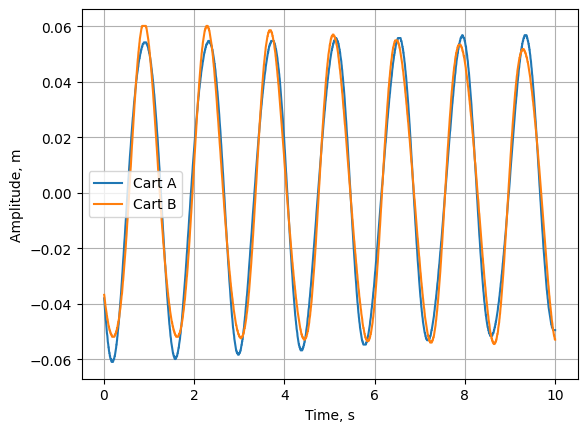

In [78]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_1.txt'
t, x1, x2 = get_signal(url)


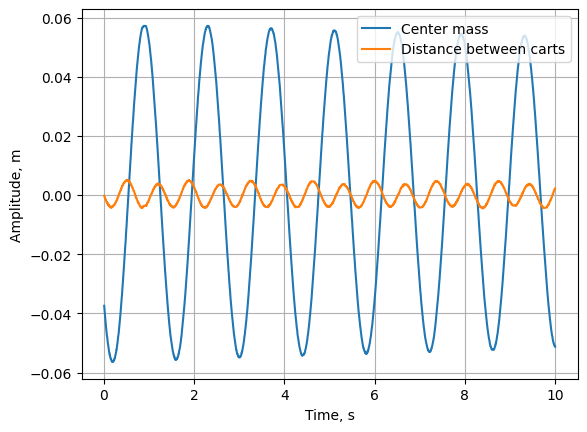

In [79]:
y1, y2 = rotate(x1, x2)


0.72

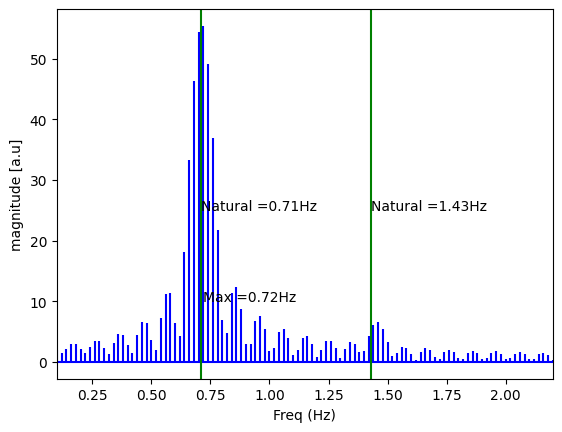

In [80]:
get_frequency(t,x1, show=True)

In [140]:
p, k, e = full_energy(x1, x2, show=False)
print(f'Energy: P {p:.2e}, K {k:.2e}')

Energy: P 2.13e-03, K 2.18e-03


## Free oscillations - Mode 2

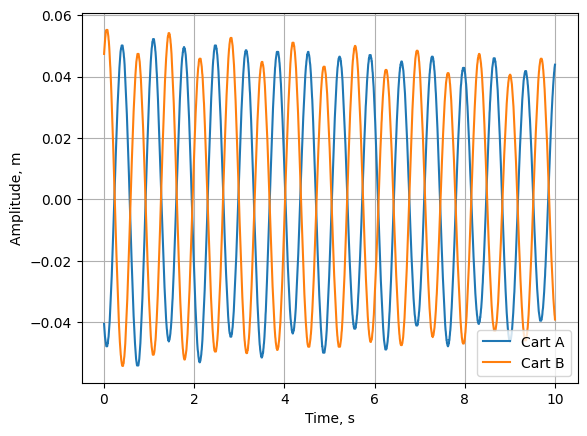

In [82]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_2.txt'
t, x1, x2 = get_signal(url)

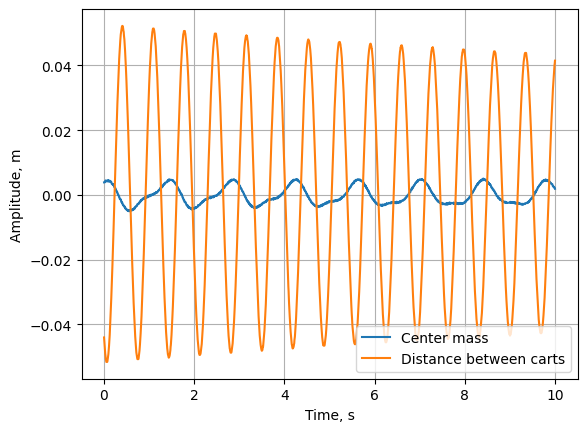

In [83]:
y1, y2 = rotate(x1, x2)


1.46

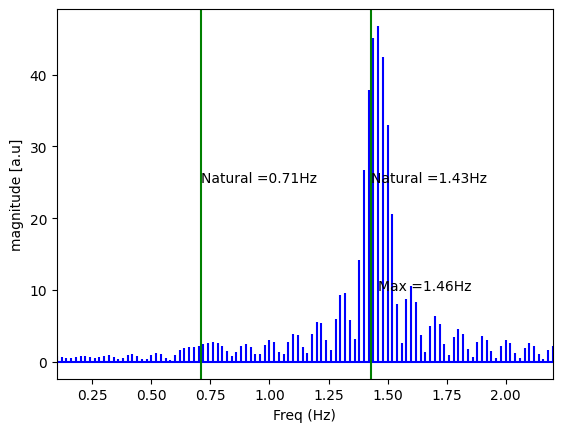

In [84]:
get_frequency(t,x1, show=True)

## Free oscillations - Mode Superpositions

### Coupled

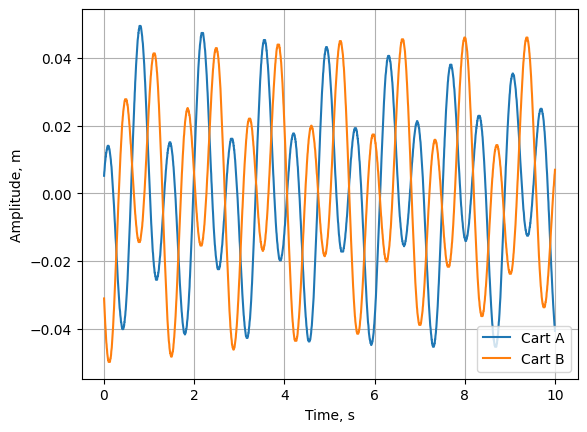

In [85]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_4.txt'
t, x1, x2 = get_signal(url)

### Decoupled

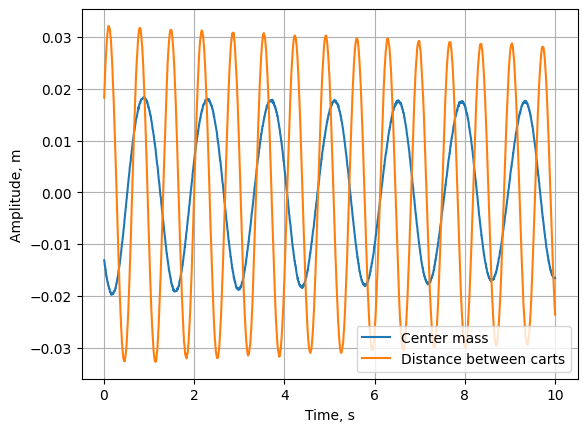

In [86]:
y1, y2 = rotate(x1, x2)


1.46

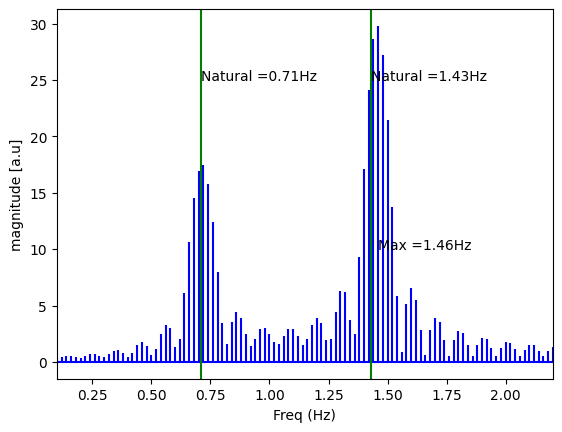

In [87]:
get_frequency(t,x1, show=True)

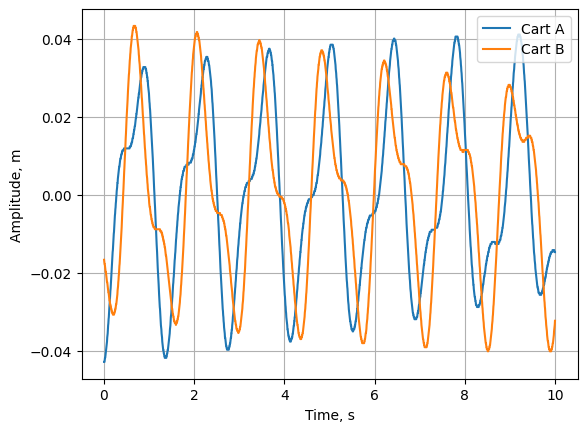

In [88]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_5.txt'
t, x1, x2 = get_signal(url)

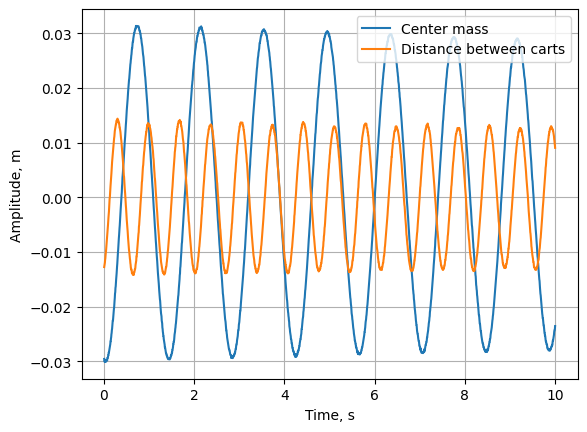

In [89]:
y1, y2 = rotate(x1, x2)

0.72

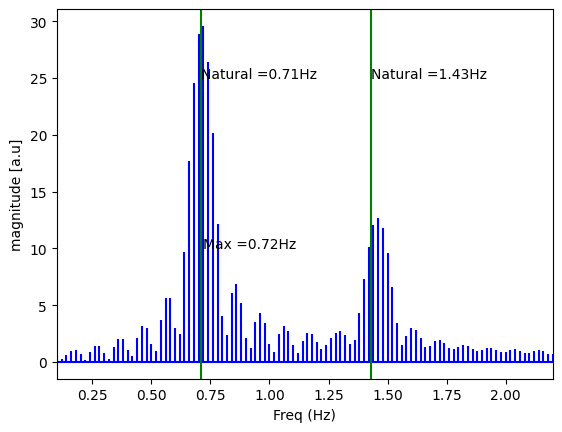

In [90]:
get_frequency(t,x1, show=True)

# Forced oscillations


## Direct measurements

In [92]:
# Springs
l = 97.95e-3 # m, spring strain
g = 9.8 # m/s^2

# left spring (attached to cart A)
weightl = 44.8e-3 #
kl = weightl * g /l
ml = 17e-3 # kg

# right spring (attached to cart B)
weightr = 44.8e-3
kr = weightr * g /l
mr = 17e-3 # kg

# middle spring (between carts A and B)
weightc = 68.6e-3
kc = weightc * g /l
mc = 11.7e-3 #

# Carts (5A, 6B, 6C)
m1 = 208.9e-3 #kg
m2 = 213.8e-3
counts = 236
length = 123e-3

## Expected natural frequencies

In [93]:
m1_eff = m1 + ml/2 + mc/2
m2_eff = m2 + mc/2 + mr/2
a = np.array([[(kl+kc)/m1_eff, -kc/m1_eff],
              [-kc/m2_eff, (kc + kr)/m2_eff]])
eigenvalues, eigenvectors = LA.eig(a)
freqs_theor = np.sqrt(eigenvalues)/2/np.pi # Herz
freqs_theor

array([1.42966672, 0.70924425])

In [185]:
def get_signal3(url, show=True):
  data = np.loadtxt(url)
  _, t, a, b, c = data.T
  x1 = a/counts * length
  x2 = b/counts * length
  x3 = c/counts * length
  x1 -= x1.mean()
  x2 -= x2.mean()
  x3 -= x3.mean()
  if show:
    plt.plot(t, x1, label='Cart A')
    plt.plot(t, x2, label='Cart B')
    plt.plot(t, x3, label='Forced cart')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    plt.ylim(-length/2, length/2)
    plt.legend()
  return t, x1, x2, x3




Energy: e1 9.75e-03, e2 4.92e-06, Full 9.75e-03


(0.020988254374296914, 0.0008712738783596039)

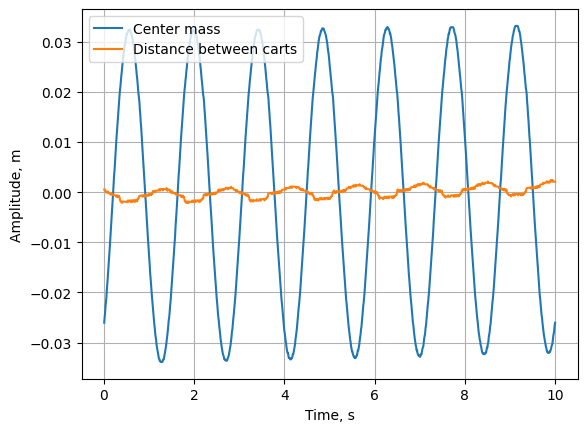

In [187]:
# Mode 1
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/fc4.5.txt'
t, x1, x2, x3 = get_signal3(url, show=False)
y1, y2 = rotate(x1, x2, show=True)
e1 = mode_energy(t, y1, m1_eff, freqs_theor[0])
e2 = mode_energy(t, y2, m2_eff, freqs_theor[1])
print(f'Energy: e1 {e1:.2e}, e2 {e2:.2e}, Full {e1+e2:.2e}')
np.mean(np.abs(y1)), np.mean(np.abs(y2))


## Energy responce to forced oscillations

### Full Potential energy

In [192]:
def potential_energy(x1, x2, x3, show=False):
  p = kl * x1**2/2
  p += kc * (x2-x1)**2 /2
  p += kr * (x2-x3)**2 /2
  if show:
    plt.plot(t, p)
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Potential energy, J')
  return p.mean()


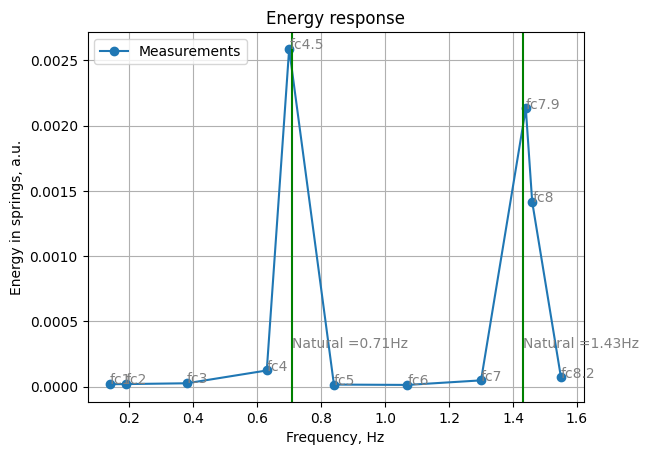

In [110]:
names = ['fc1', 'fc2', 'fc3', 'fc4', 'fc4.5','fc5', 'fc6', 'fc7', 'fc7.9',  'fc8.2', 'fc8']
fw = np.array([])
energy = np.array([])
for name in names:
  url = f'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/{name}.txt'
  t, x1, x2, x3 = get_signal3(url, show=False)
  fw = np.append(fw, get_frequency(t, x3, show=False))
  energy = np.append(energy, potential_energy(x1, x2, x3, show=False))

idx = np.argsort(fw) # sorting
plt.plot(fw[idx], energy[idx], linestyle='-', marker='o', label='Measurements')
for ind in idx:
  plt.annotate(names[ind], xy=(fw[ind], energy[ind]), color='gray')
plt.grid()
plt.xlabel('Frequency, Hz')
plt.ylabel('Energy in springs, a.u.')
plt.title('Energy response')
for freq in freqs_theor:
  plt.axvline(freq, c='g')
  plt.annotate(fr'Natural ={freq:.2f}Hz',xy=(freq, np.mean(energy)/2), color='gray')
plt.legend()

### Energy associated with main variables

$$
E_i \approx \frac{1}{2} m_i A_i^2 \omega_i^2
$$

In [193]:
def mode_energy(t, x, m, freq0):
  omega0 = freq0 * 2*np.pi
  magnitude2 = 2 * np.mean(x**2)
  energy = m * magnitude2 * omega0**2 /2
  return energy


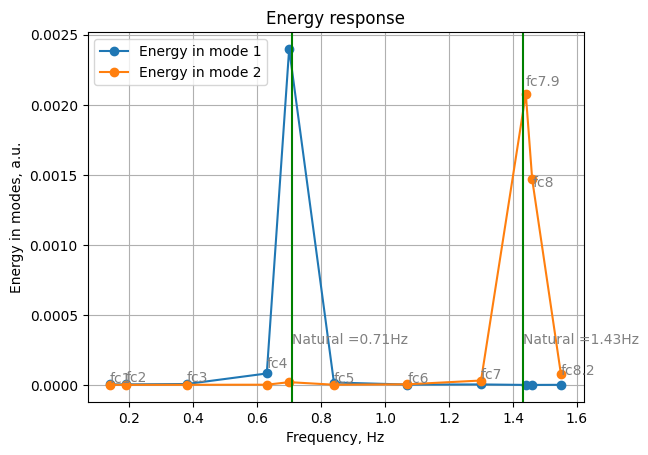

In [194]:
names = ['fc1', 'fc2', 'fc3', 'fc4', 'fc4.5','fc5', 'fc6', 'fc7', 'fc7.9',  'fc8.2', 'fc8']
fw = np.array([])
energy1 = np.array([])
energy2 = np.array([])
for name in names:
  url = f'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/{name}.txt'
  t, x1, x2, x3 = get_signal3(url, show=False)
  fw = np.append(fw, get_frequency(t, x3, show=False))
  y1, y2 = rotate(x1, x2, show=False)
  energy1 = np.append(energy1, mode_energy(t, y1, m1_eff, freqs_theor[1]))
  energy2 = np.append(energy2, mode_energy(t, y2, m2_eff, freqs_theor[0]))

idx = np.argsort(fw) # sorting
plt.plot(fw[idx], energy1[idx], linestyle='-', marker='o', label='Energy in mode 1')
plt.plot(fw[idx], energy2[idx], linestyle='-', marker='o', label='Energy in mode 2')

for ind in idx:
  plt.annotate(names[ind], xy=(fw[ind], energy[ind]), color='gray')
plt.grid()
plt.xlabel('Frequency, Hz')
plt.ylabel('Energy in modes, a.u.')
plt.title('Energy response')
for freq in freqs_theor:
  plt.axvline(freq, c='g')
  plt.annotate(fr'Natural ={freq:.2f}Hz',xy=(freq, np.mean(energy)/2), color='gray')
plt.legend()

### Forced oscillations in resonance and out of resonance

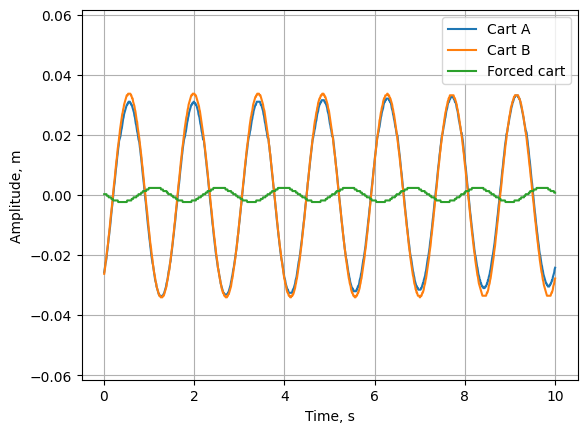

In [102]:
# Mode 1
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/fc4.5.txt'
t, x1, x2, x3 = get_signal3(url)

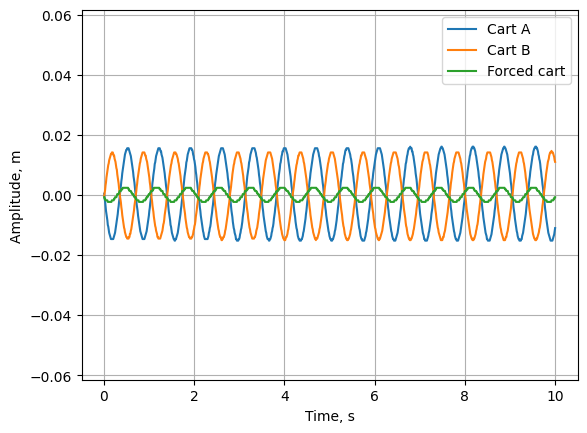

In [112]:
# Mode 2
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/fc7.9.txt'
t, x1, x2, x3 = get_signal3(url)

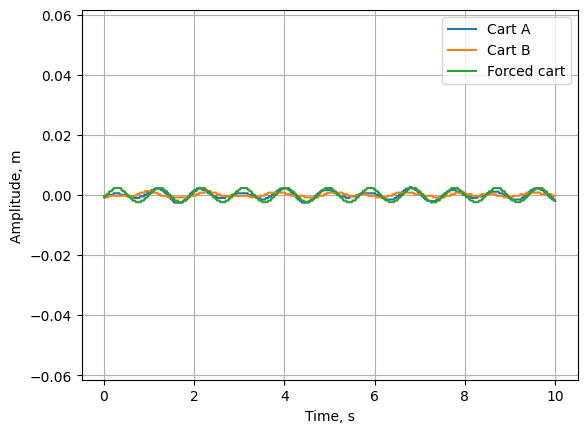

In [111]:
# No resonance
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/fc6.txt'
t, x1, x2, x3 = get_signal3(url)